# **Метрики удобочитаемости, лексического разнообразия и пр. для датасета**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import colorsys

## Объединение данных в один датасет

In [240]:
# читаем несколько файлов с метриками (для разных авторов)
df1 = pd.read_csv('TRAIN_500words_lemmatized_metrics_part1.csv', sep=',') 
df1.index = df1['Unnamed: 0']
df1['author'].unique()

array(['anton-chekhov', 'dmitriy-mamin-sibiryak', 'fedor-dostoevskii',
       nan], dtype=object)

In [241]:
df2 = pd.read_csv('TRAIN_500words_lemmatized_metrics_part2.csv', sep=',') 
df2.index = df2['Unnamed: 0']
df2['author'].unique()

array(['fedor-dostoevskii', 'ivan-goncharov', 'ivan-turgenev',
       'lev-tolstoi', 'maksim-gorkii', 'nikolai-gogol', 'sergey-aksakov'],
      dtype=object)

In [242]:
# делаем общий датасет для всех авторов
df = df1.append(df2)

In [243]:
df['author'].unique()

array(['anton-chekhov', 'dmitriy-mamin-sibiryak', 'fedor-dostoevskii',
       nan, 'ivan-goncharov', 'ivan-turgenev', 'lev-tolstoi',
       'maksim-gorkii', 'nikolai-gogol', 'sergey-aksakov'], dtype=object)

In [244]:
# удаляем одинаковые строки в объединенном датасете
df = df.drop_duplicates(['Unnamed: 0'])
df = df.drop(['Unnamed: 0', 'Unnamed: 21', 'Unnamed: 20'], axis=1)

In [245]:
df.drop(df[df['n_sents'].isna()==True].index, inplace=True) # это образовавшаяся пустая строка на стыке двух кусков датасета

In [246]:
df.shape

(9758, 47)

In [247]:
# показатели среднего/женского/мужского рода, пассивного/активного залога и т.д. выражаем как долю от общего числа слов в куске текста
for column in ['neut',
       'masc', 'femn', 'plur','sing', 'pres', 'past', 'futr', 'pssv', 'actv', '2per',
       '3per', '1per']:
    df[column] = df[column] / df['n_words']

## Часть 1: Изучить особенности данных

### 1.1 Основные статистики для всех признаков

In [248]:
df.describe(include='all')

,n_sents,n_words,n_unique_words,n_long_words,n_complex_words,n_simple_words,n_monosyllable_words,n_polysyllable_words,n_chars,n_letters,...,mttr,dttr,mattr,msttr,mtld,mamtld,hdd,simpson_index,hapax_index,author
count,9758.000000,9758.000000,9758.000000,9758.000000,9758.000000,9758.000000,9758.000000,9758.000000,9758.000000,9758.000000,...,9758.000000,9758.000000,9758.000000,9758.000000,9758.000000,9758.000000,9758.000000,9758.000000,9758.000000,9758
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fedor-dostoevskii
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2061
mean,36.961263,489.581574,315.386862,204.047346,69.554007,388.698811,145.277106,312.975712,3109.229555,2433.536790,...,0.026640,39.083328,0.871354,0.871167,235.917188,192.732020,0.904603,171.382054,1412.224115,NaN
std,14.872039,27.121768,31.985178,28.315005,19.424879,29.914630,24.073362,30.860039,214.534774,239.895049,...,0.005355,7.984645,0.031885,0.032511,114.180584,100.852598,0.021239,47.965324,315.863779,NaN
min,9.000000,365.000000,190.000000,103.000000,0.000000,0.000000,0.000000,2.000000,2418.000000,9.000000,...,0.012315,18.578103,0.696193,0.685000,42.872285,1.000000,0.769989,38.175095,550.337349,NaN
25%,27.000000,470.000000,293.000000,184.000000,56.000000,371.000000,129.000000,293.000000,2959.000000,2277.000000,...,0.022766,33.223768,0.851062,0.851111,153.608633,128.952553,0.891624,137.661586,1182.625069,NaN
50%,35.000000,491.000000,317.000000,205.000000,68.000000,390.000000,144.000000,315.000000,3105.000000,2437.000000,...,0.026201,38.166929,0.873422,0.873333,209.850990,179.154376,0.906289,164.341960,1373.702378,NaN
75%,44.000000,508.000000,339.000000,224.000000,82.000000,408.000000,161.000000,334.000000,3254.000000,2593.750000,...,0.030099,43.925351,0.894428,0.894000,282.090998,252.036413,0.919588,197.060749,1594.123624,NaN


In [249]:
df['author'].value_counts()

fedor-dostoevskii         2061
lev-tolstoi               2004
maksim-gorkii             1498
ivan-goncharov            1255
dmitriy-mamin-sibiryak     728
ivan-turgenev              660
sergey-aksakov             581
nikolai-gogol              533
anton-chekhov              438
Name: author, dtype: int64

In [250]:
books = df.copy()

### 1.2 Пропущенные значения

In [251]:
# посмотрим, какую долю занимают пропущенные значения для каждого признака от общего числа объектов
books.isna().sum()/len(df)

n_sents                        0.000000
n_words                        0.000000
n_unique_words                 0.000000
n_long_words                   0.000000
n_complex_words                0.000000
n_simple_words                 0.000000
n_monosyllable_words           0.000000
n_polysyllable_words           0.000000
n_chars                        0.000000
n_letters                      0.000000
n_spaces                       0.000000
n_syllables                    0.000000
n_punctuations                 0.000000
flesch_kincaid_grade           0.000000
flesch_reading_easy            0.000000
coleman_liau_index             0.000000
smog_index                     0.000000
automated_readability_index    0.000000
lix                            0.000000
masc                           0.000205
femn                           0.000102
neut                           0.000205
sing                           0.000000
plur                           0.000205
past                           0.000307


* В данном случае пропущенные значения присутствуют в показателях: женского/мужского/нейтрального родов, множественного числа, настоящего/прошедшего/будущего времен, активного/пассивного залогов, первого/второго/третьего лиц. 
* Для каждого из этих показателей пропущенное значение означает, что этот род/число/время/залог/лицо не были использованы и найдены в тексте. 
* Это означает, что пропущенные значения **можно заменять на нули**.

In [252]:
books = books.fillna(value=0)

In [253]:
books.describe()

,n_sents,n_words,n_unique_words,n_long_words,n_complex_words,n_simple_words,n_monosyllable_words,n_polysyllable_words,n_chars,n_letters,...,sttr,mttr,dttr,mattr,msttr,mtld,mamtld,hdd,simpson_index,hapax_index
count,9758.000000,9758.000000,9758.000000,9758.000000,9758.000000,9758.000000,9758.000000,9758.000000,9758.000000,9758.000000,...,9758.000000,9758.000000,9758.000000,9758.000000,9758.000000,9758.000000,9758.000000,9758.000000,9758.000000,9758.000000
mean,36.961263,489.581574,315.386862,204.047346,69.554007,388.698811,145.277106,312.975712,3109.229555,2433.536790,...,0.924731,0.026640,39.083328,0.871354,0.871167,235.917188,192.732020,0.904603,171.382054,1412.224115
std,14.872039,27.121768,31.985178,28.315005,19.424879,29.914630,24.073362,30.860039,214.534774,239.895049,...,0.015741,0.005355,7.984645,0.031885,0.032511,114.180584,100.852598,0.021239,47.965324,315.863779
min,9.000000,365.000000,190.000000,103.000000,0.000000,0.000000,0.000000,2.000000,2418.000000,9.000000,...,0.841836,0.012315,18.578103,0.696193,0.685000,42.872285,1.000000,0.769989,38.175095,550.337349
25%,27.000000,470.000000,293.000000,184.000000,56.000000,371.000000,129.000000,293.000000,2959.000000,2277.000000,...,0.914692,0.022766,33.223768,0.851062,0.851111,153.608633,128.952553,0.891624,137.661586,1182.625069
50%,35.000000,491.000000,317.000000,205.000000,68.000000,390.000000,144.000000,315.000000,3105.000000,2437.000000,...,0.926134,0.026201,38.166929,0.873422,0.873333,209.850990,179.154376,0.906289,164.341960,1373.702378
75%,44.000000,508.000000,339.000000,224.000000,82.000000,408.000000,161.000000,334.000000,3254.000000,2593.750000,...,0.936127,0.030099,43.925351,0.894428,0.894000,282.090998,252.036413,0.919588,197.060749,1594.123624
max,161.000000,699.000000,460.000000,316.000000,160.000000,513.000000,237.000000,448.000000,4340.000000,3522.000000,...,0.965924,0.053827,81.203779,0.946189,0.952500,695.270270,521.000000,0.958615,432.359551,3043.637707


### 1.3 Ошибочные значения и выбросы

In [254]:
#original_text = pd.read_csv('https://raw.githubusercontent.com/anyakazachkova/project/kirill-december/Kirill/datasets/TRAIN_500words_lemmatized.csv?token=GHSAT0AAAAAAB2L7SLI4N4ZR5JAQQSM4GS4Y5C7WKQ')
original_text['text'].iloc[5940] # в "Войне и мире" есть отрывки на французском языке. Их лучше убрать, т.к. они будут выбросами

# такие отрывки можно вычислить по маленькому числу букв, так как латиница не считается в n_letters

'Eh bien, chère Marie, je vous avouerai, que, malgré son extrême jeunesse, son départ pour l’armée a été un grand chagrin pour moi. Le jeune homme, dont je vous parlais cet été, a tant de noblesse, de véritable jeunesse qu’on rencontre si rarement dans le siècle ou nous vivons parmi nos vieillards de vingt ans. Il a surtout tant de franchise et de cœur. Il est tellement pur et poétique, que mes relations avec lui, quelque passagères qu’elles fussent, ont été l’une des plus douces jouissances de mon pauvre cœur, qui a déjà tant souffert. Je vous raconterai un jour nos adieux et tout ce qui s’est dit en partant. Tout cela est encore trop frais. Ah! chère amie, vous êtes heureuse de ne pas connaître ces jouissances et ces peines si poignantes. Vous êtes heureuse, puisque les dernières — sont ordinairement les plus fortes! Je sais fort bien que le comte Nicolas est trop jeune pour pouvoir jamais devenir pour moi quelque chose de plus qu’un ami, mais cette douce amitié, ces relations si poé

In [255]:
books = books[books['n_letters']  > 1000] # примерно так отсекаются все куски, где много французских слов

Сначала посмотрим на boxplot.

In [256]:
books.columns

Index(['n_sents', 'n_words', 'n_unique_words', 'n_long_words',
       'n_complex_words', 'n_simple_words', 'n_monosyllable_words',
       'n_polysyllable_words', 'n_chars', 'n_letters', 'n_spaces',
       'n_syllables', 'n_punctuations', 'flesch_kincaid_grade',
       'flesch_reading_easy', 'coleman_liau_index', 'smog_index',
       'automated_readability_index', 'lix', 'masc', 'femn', 'neut', 'sing',
       'plur', 'past', 'pres', 'futr', 'pssv', 'actv', '3per', '1per', '2per',
       'ttr', 'rttr', 'cttr', 'httr', 'sttr', 'mttr', 'dttr', 'mattr', 'msttr',
       'mtld', 'mamtld', 'hdd', 'simpson_index', 'hapax_index', 'author'],
      dtype='object')

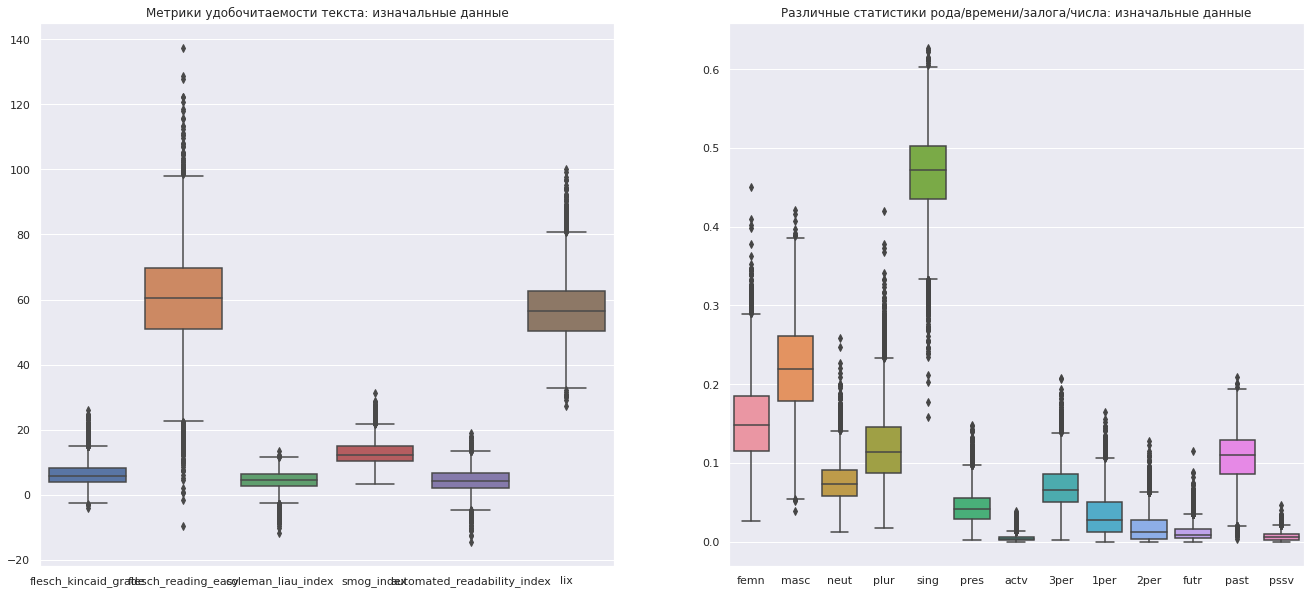

In [257]:
fig = plt.figure(figsize = (35, 10))

fig.add_subplot(131)
sns.boxplot(data=books[['flesch_kincaid_grade', 'flesch_reading_easy', 'coleman_liau_index',
       'smog_index', 'automated_readability_index', 'lix']])
plt.title('Метрики удобочитаемости текста: изначальные данные', fontsize=12)

fig.add_subplot(132)
sns.boxplot(data=books[['femn', 'masc',
       'neut', 'plur', 'sing', 'pres', 'actv', '3per', '1per', '2per', 'futr',
       'past', 'pssv']])
plt.title('Различные статистики рода/времени/залога/числа: изначальные данные', fontsize=12)
plt.show()


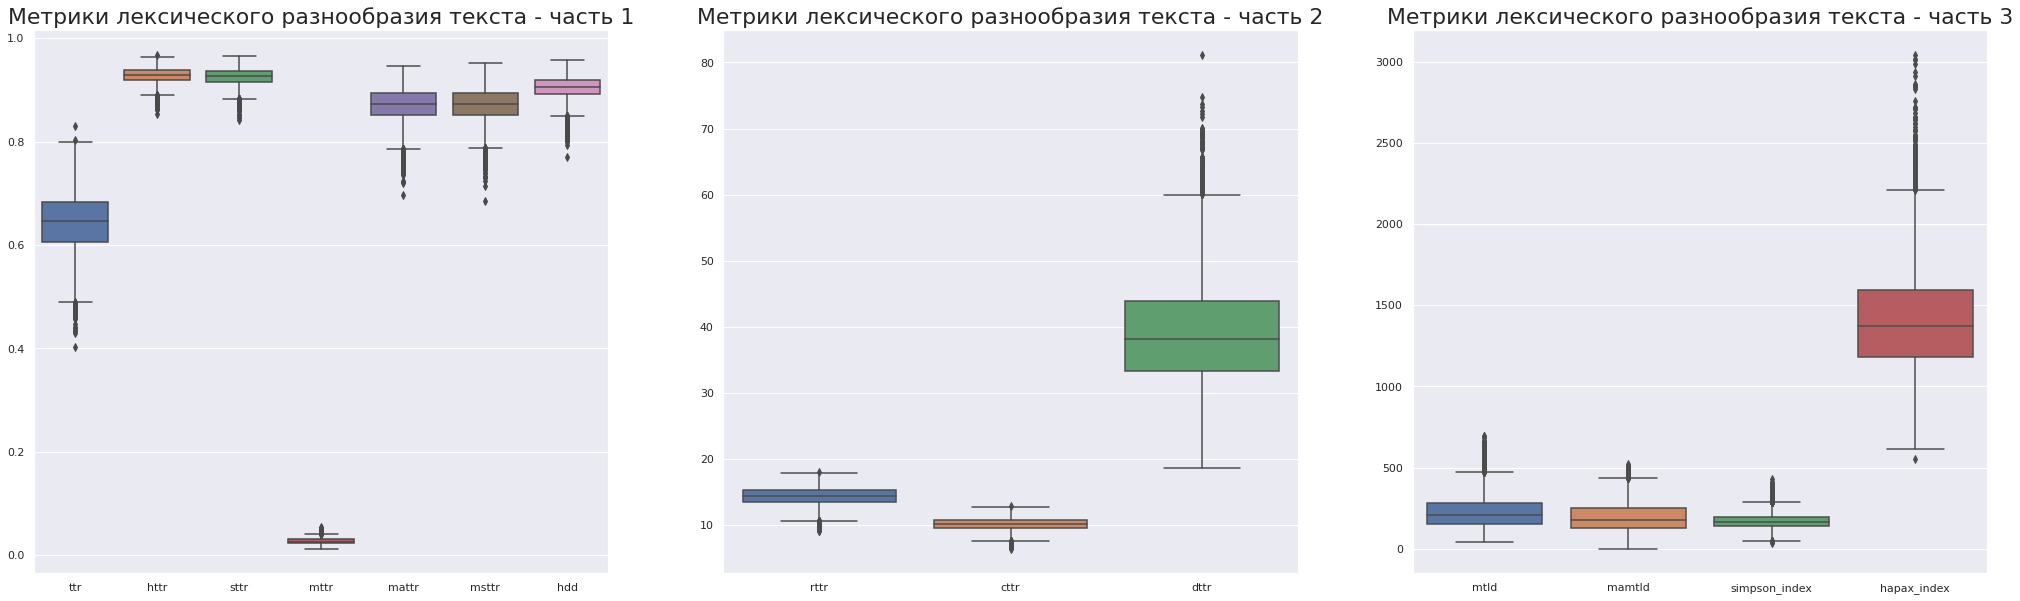

In [258]:
fig = plt.figure(figsize = (35, 10))

fig.add_subplot(131)
sns.boxplot(data=books[['ttr',
       'httr', 'sttr', 'mttr', 'mattr', 'msttr',
       'hdd']])
plt.title('Метрики лексического разнообразия текста - часть 1', fontsize=22)

fig.add_subplot(132)
sns.boxplot(data=books[['rttr', 'cttr', 'dttr']])
plt.title('Метрики лексического разнообразия текста - часть 2', fontsize=22)

fig.add_subplot(133)
sns.boxplot(data=books[['mtld', 'mamtld', 'simpson_index', 'hapax_index']])
plt.title('Метрики лексического разнообразия текста - часть 3', fontsize=22)

plt.show()

In [259]:
lower_bound = books['flesch_reading_easy'].quantile(q=0.025)
upper_bound = books['flesch_reading_easy'].quantile(q=0.975)

to_easy = books[books['flesch_reading_easy'] > upper_bound]
to_hard = books[books['flesch_reading_easy'] < lower_bound]

print(set(to_easy.index[:-16]))
print(set(to_hard.index[:-16]))

{'2962 fedor-dostoevskii podrostok', '431 anton-chekhov vishnevyi-sad', '1909 fedor-dostoevskii bratya-karamazovy', '6056 lev-tolstoi voina-i-mir', '181 anton-chekhov drama-na-okhote', '449 dmitriy-mamin-sibiryak alenushkiny-skazki', '4675 ivan-turgenev otcy-i-deti', '2089 fedor-dostoevskii bratya-karamazovy', '3917 ivan-goncharov oblomov', '4948 ivan-turgenev zapiski-okhotnika', '5866 lev-tolstoi voina-i-mir', '7324 maksim-gorkii na-dne', '7120 lev-tolstoi zhivoi-trup', '5926 lev-tolstoi voina-i-mir', '2812 fedor-dostoevskii podrostok', '5130 ivan-turgenev zapiski-okhotnika', '4656 ivan-turgenev otcy-i-deti', '6167 lev-tolstoi voina-i-mir', '6033 lev-tolstoi voina-i-mir', '81 anton-chekhov chaika', '348 anton-chekhov tri-sestry', '3884 ivan-goncharov oblomov', '364 anton-chekhov tri-sestry', '5885 lev-tolstoi voina-i-mir', '232 anton-chekhov drama-na-okhote', '3837 ivan-goncharov oblomov', '5929 lev-tolstoi voina-i-mir', '55 anton-chekhov barynya', '7345 maksim-gorkii na-dne', '456 dm

In [260]:
lower_bound = books['mttr'].quantile(q=0.025)
upper_bound = books['mttr'].quantile(q=0.975)

to_diverse = books[books['mttr'] > upper_bound]
to_similar = books[books['mttr'] < lower_bound]

print(set(to_diverse.index[:-16]))
print(set(to_similar.index[:-16]))

{'6296 lev-tolstoi voina-i-mir', '1980 fedor-dostoevskii bratya-karamazovy', '6145 lev-tolstoi voina-i-mir', '3918 ivan-goncharov oblomov', '2465 fedor-dostoevskii idiot', '3186 fedor-dostoevskii unizhennye-i-oskorblennye', '449 dmitriy-mamin-sibiryak alenushkiny-skazki', '4675 ivan-turgenev otcy-i-deti', '7324 maksim-gorkii na-dne', '454 dmitriy-mamin-sibiryak alenushkiny-skazki', '2146 fedor-dostoevskii bratya-karamazovy', '1763 fedor-dostoevskii bratya-karamazovy', '2947 fedor-dostoevskii podrostok', '1765 fedor-dostoevskii bratya-karamazovy', '3081 fedor-dostoevskii unizhennye-i-oskorblennye', '1965 fedor-dostoevskii bratya-karamazovy', '7346 maksim-gorkii na-dne', '1937 fedor-dostoevskii bratya-karamazovy', '2247 fedor-dostoevskii idiot', '1762 fedor-dostoevskii bratya-karamazovy', '2026 fedor-dostoevskii bratya-karamazovy', '2035 fedor-dostoevskii bratya-karamazovy', '5481 lev-tolstoi anna-karenina', '5974 lev-tolstoi voina-i-mir', '7345 maksim-gorkii na-dne', '2759 fedor-dostoev

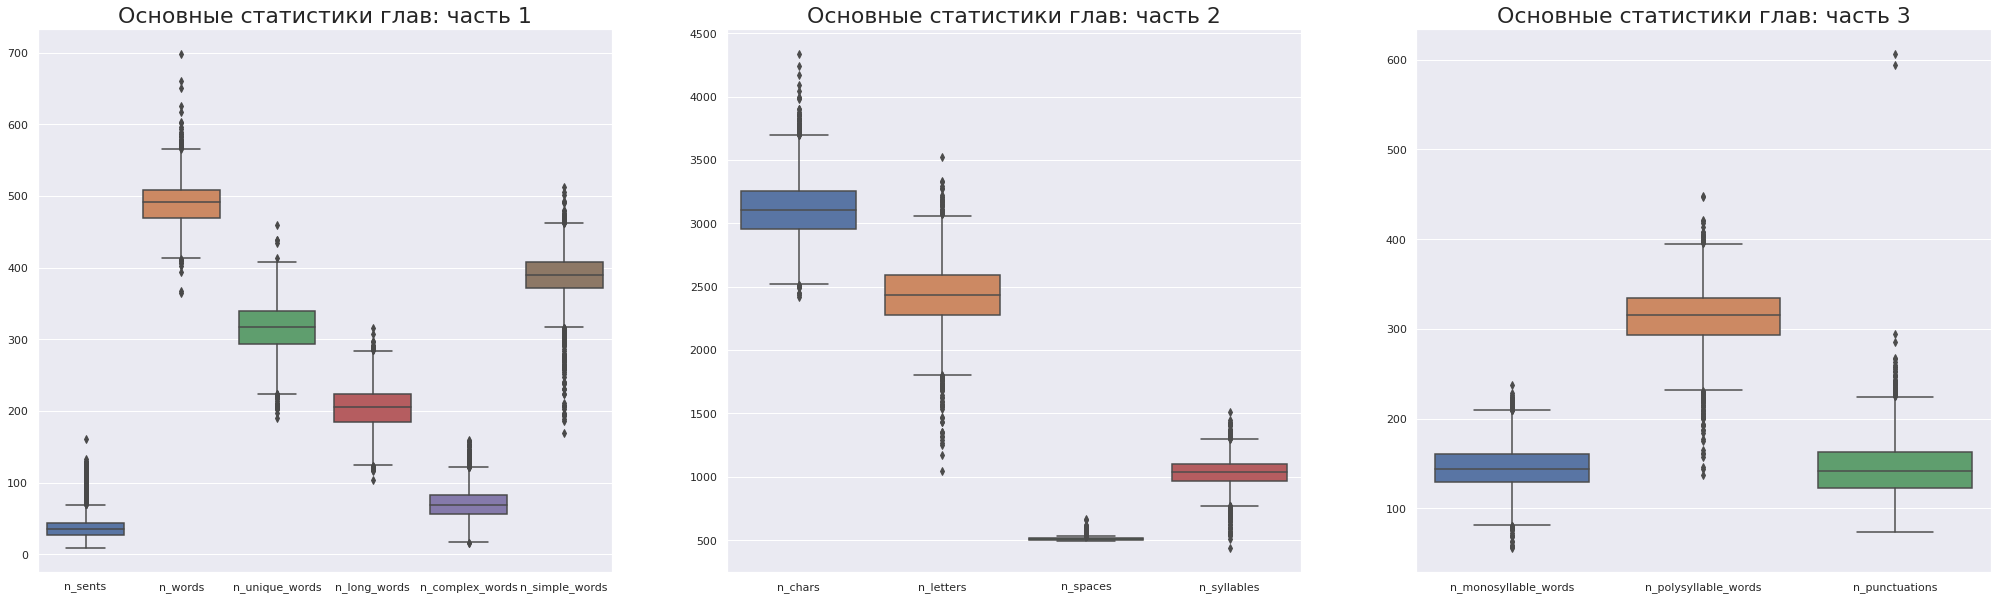

In [261]:
fig = plt.figure(figsize = (35, 10))

fig.add_subplot(131)
sns.boxplot(data=books[['n_sents', 'n_words', 'n_unique_words', 'n_long_words',
       'n_complex_words', 'n_simple_words']])
plt.title('Основные статистики глав: часть 1', fontsize=22)

fig.add_subplot(132)
sns.boxplot(data=books[['n_chars', 'n_letters', 'n_spaces',
       'n_syllables']])
plt.title('Основные статистики глав: часть 2', fontsize=22)

fig.add_subplot(133)
sns.boxplot(data=books[['n_monosyllable_words',
       'n_polysyllable_words', 'n_punctuations']])
plt.title('Основные статистики глав: часть 3', fontsize=22)

plt.show()

In [263]:
lower_bound = df['n_words'].quantile(q=0.025)
upper_bound = df['n_words'].quantile(q=0.975)

to_big = df[df['n_words'] > upper_bound]
to_small = df[df['n_words'] < lower_bound]

print(set(to_big.index[:-16]))
print(set(to_small.index[:-16]))

{'9223 sergey-aksakov detskie-gody-bagrova-vnuka', '612 dmitriy-mamin-sibiryak hleb', '4130 ivan-goncharov obryv', '526 dmitriy-mamin-sibiryak hleb', '9640 sergey-aksakov zapiski-ruzheynogo-ohotnika-orenburgskoy-gubernii', '521 dmitriy-mamin-sibiryak hleb', '9376 sergey-aksakov detskie-gody-bagrova-vnuka', '482 dmitriy-mamin-sibiryak bratya-gordeevy', '3770 ivan-goncharov oblomov', '5940 lev-tolstoi voina-i-mir', '9635 sergey-aksakov zapiski-ruzheynogo-ohotnika-orenburgskoy-gubernii', '3600 ivan-goncharov fregat-pallada', '4048 ivan-goncharov obryv', '8656 nikolai-gogol myortvye-dushi', '8804 nikolai-gogol myortvye-dushi', '722 dmitriy-mamin-sibiryak hleb', '596 dmitriy-mamin-sibiryak hleb', '1451 fedor-dostoevskii besy', '1839 fedor-dostoevskii bratya-karamazovy', '700 dmitriy-mamin-sibiryak hleb', '655 dmitriy-mamin-sibiryak hleb', '2923 fedor-dostoevskii podrostok', '3285 ivan-goncharov fregat-pallada', '1170 fedor-dostoevskii besy', '4507 ivan-turgenev dvoryanskoe-gnezdo', '9224 se

In [264]:
# удаляем некоторые метрики
books = books.drop(['n_sents', 'n_words', 'n_unique_words', 'n_long_words',
       'n_complex_words', 'n_simple_words', 'n_monosyllable_words',
       'n_polysyllable_words', 'n_chars', 'n_letters', 'n_spaces',
       'n_syllables', 'n_punctuations'], axis=1)

## Часть 2: Поведение признаков и связь с целевой переменной

Для начала придется закодировать целевую переменную - автора, т.к. сейчас это единственный категориальный столбец.

In [265]:
from sklearn.preprocessing import OrdinalEncoder
import numpy as np

encoder = OrdinalEncoder()
books['author_num'] = encoder.fit_transform(np.array(books['author']).reshape(-1,1))

In [266]:
books['author_num'].value_counts()

2.0    2061
5.0    1997
6.0    1498
3.0    1255
1.0     728
4.0     660
8.0     581
7.0     533
0.0     438
Name: author_num, dtype: int64

In [267]:
books.describe()

,flesch_kincaid_grade,flesch_reading_easy,coleman_liau_index,smog_index,automated_readability_index,lix,masc,femn,neut,sing,...,mttr,dttr,mattr,msttr,mtld,mamtld,hdd,simpson_index,hapax_index,author_num
count,9751.000000,9751.000000,9751.000000,9751.000000,9751.000000,9751.000000,9751.000000,9751.000000,9751.000000,9751.000000,...,9751.000000,9751.000000,9751.000000,9751.000000,9751.000000,9751.000000,9751.000000,9751.000000,9751.000000,9751.000000
mean,6.336600,59.842227,4.358475,12.849406,4.381996,56.958237,0.220532,0.152410,0.076017,0.465658,...,0.026632,39.091369,0.871380,0.871193,235.990351,192.780944,0.904626,171.408835,1412.498385,3.959286
std,3.611919,14.675910,2.727879,3.594000,3.415927,9.132360,0.058312,0.051732,0.025701,0.053436,...,0.005344,7.980159,0.031863,0.032491,114.177518,100.862942,0.021207,47.954237,315.772929,2.151322
min,-4.168028,-9.557136,-11.582535,3.437316,-14.397990,27.273184,0.038877,0.026585,0.012632,0.157996,...,0.012315,18.578103,0.696193,0.685000,42.872285,1.000000,0.769989,38.175095,550.337349,0.000000
25%,3.842187,50.909179,2.691420,10.328584,2.049646,50.470986,0.178606,0.115010,0.058065,0.434698,...,0.022759,33.234345,0.851077,0.851111,153.630395,129.038292,0.891649,137.716216,1182.796279,2.000000
50%,5.769362,60.551952,4.537530,12.360415,4.310382,56.335032,0.218679,0.147638,0.073171,0.471616,...,0.026195,38.174503,0.873443,0.873333,209.917335,179.198777,0.906291,164.361001,1373.864329,4.000000
75%,8.273507,69.834833,6.251558,14.949377,6.566715,62.561412,0.261663,0.184567,0.091319,0.502299,...,0.030089,43.938941,0.894437,0.894000,282.117397,252.151600,0.919590,197.060139,1594.483728,6.000000
max,26.126434,137.442441,13.516774,31.412220,19.131558,100.118826,0.421525,0.450855,0.258517,0.627397,...,0.053827,81.203779,0.946189,0.952500,695.270270,521.000000,0.958615,432.359551,3043.637707,8.000000


### 2.1 Корреляции признаков

Все признаки точно не придется одновременно использовать, потому что многие из них слишком похожи. Посмотрим на корреляции и уберем одинаковые.

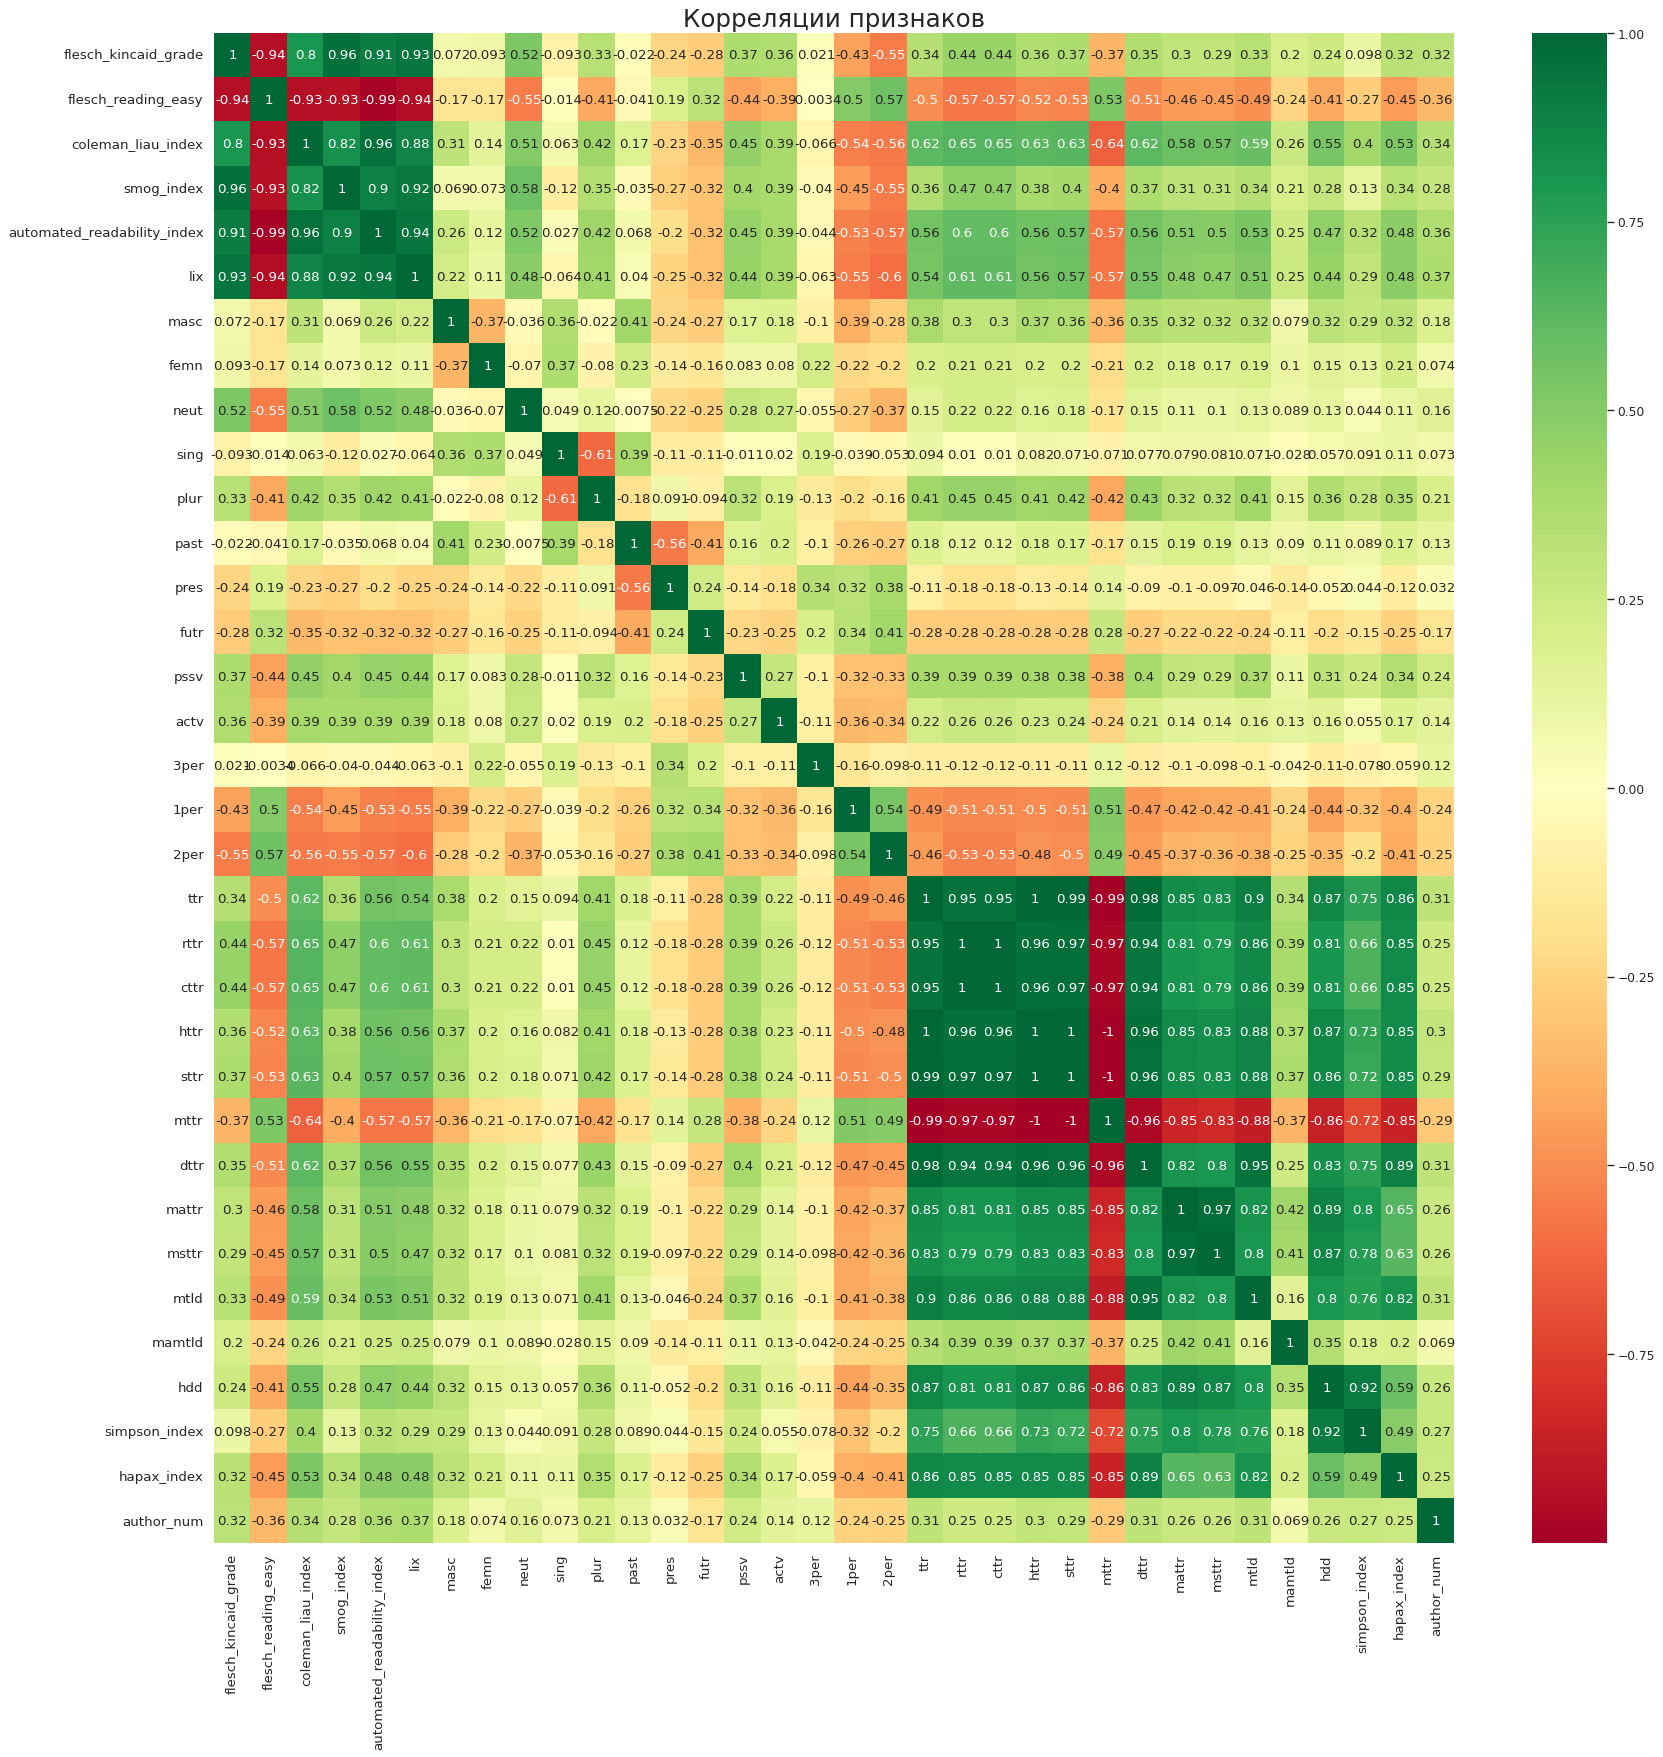

In [268]:
plt.figure(figsize=(25,25), dpi= 80)
sns.heatmap(books.corr(), xticklabels=books.corr().columns, yticklabels=books.corr().columns, cmap='RdYlGn', center=0, annot=True)

plt.title('Корреляции признаков', fontsize=22)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

* Судя по корреляциям, **метрики удобочитаемости текста** дают очень похожие результаты между собой, поэтому есть смысл оставить только какую-либо одну вместо всех. Можно оставить только **smog_index**. Чем больше значение этой метрики, тем сложнее текст.

* Также метрики лексического разнообразия похожи между собой, но среди них есть не только совсем одинаковые. Можно оставить такие:
  * **hdd** Наиболее достоверная реализация алгоритма VocD (2010, McCarthy & Jarvis). В основе алгоритм лежит метод случайного отбора из текста сегментов длиной от 32 до 50 слов и вычисления для них TTR с последующим усреднением.
  * **mttr** Модификация метрики TTR с использованием логарифмической функции (1966, Mass). Наиболее стабильная метрика в отношении длины текста.



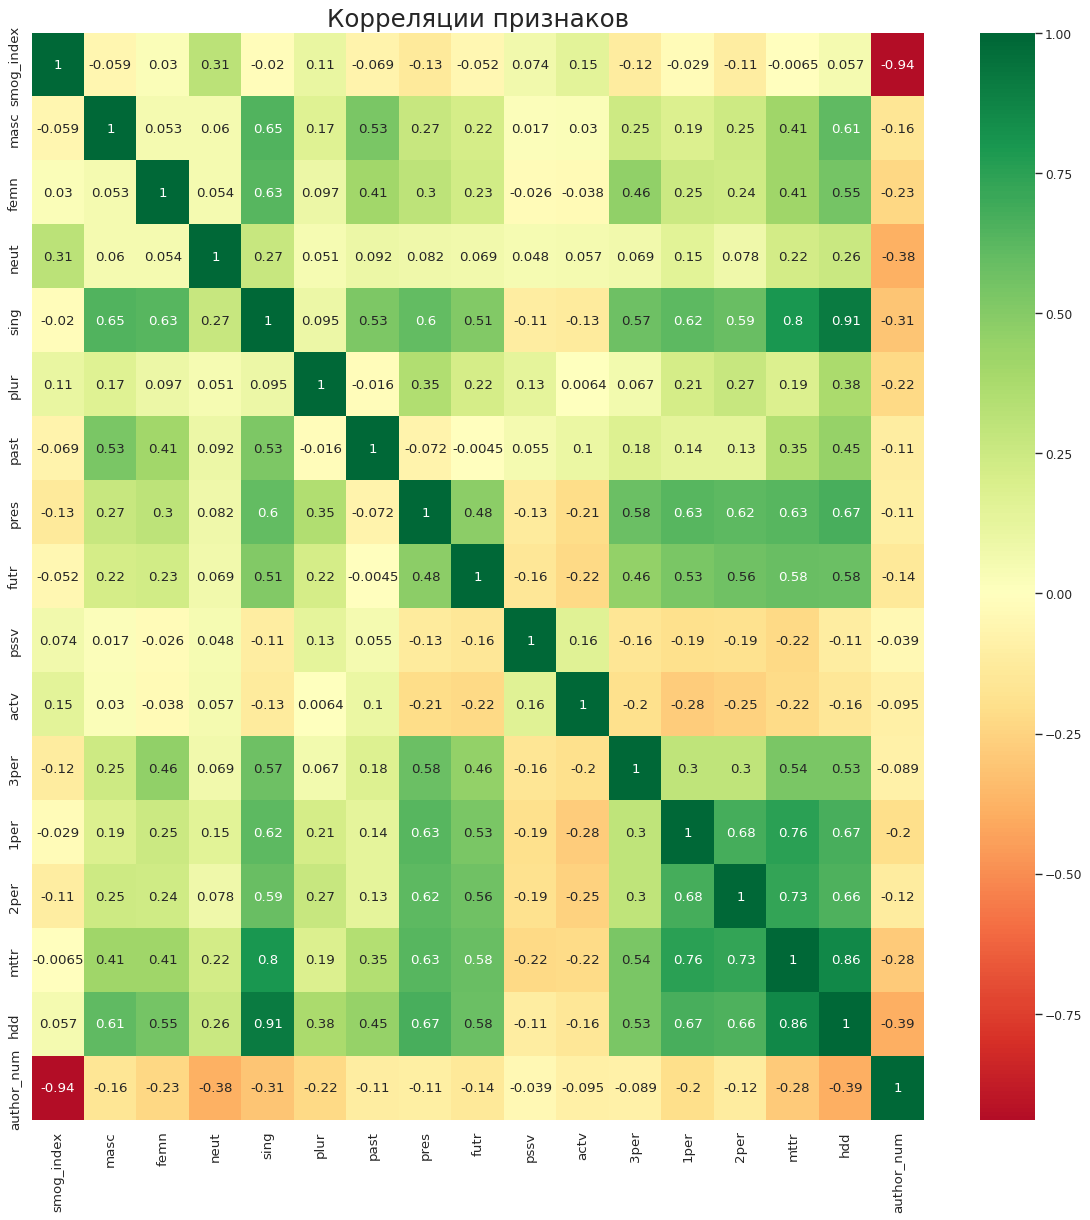

In [269]:
# удалим ненужные столбцы
books = books.drop(['flesch_kincaid_grade', 'flesch_reading_easy', 'coleman_liau_index', 'automated_readability_index',
                    'ttr', 'rttr', 'cttr', 'httr', 'sttr', 'dttr', 'mattr', 'msttr', 'mamtld', 'hapax_index', 'mtld', 
                    'simpson_index', 'lix'], axis=1)

authors_data = books['author']
books_norm = books.drop(['author'], axis=1)
# нормируем векторы
books_norm = books_norm.apply(lambda metric: metric/metric.sum(), axis=1)

# еще раз посмотрим на корреляции
plt.figure(figsize=(18,18), dpi= 80)
sns.heatmap(books_norm.corr(), xticklabels=books_norm.corr().columns, yticklabels=books_norm.corr().columns, cmap='RdYlGn', center=0, annot=True)

plt.title('Корреляции признаков', fontsize=22)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

### 2.1 Поведение каждого признака в отдельности

In [270]:
def metrics_density_by_author(m):
  sns.set(rc={'figure.figsize':(15,10)})
  for author in books['author'].unique():
    snsplot = sns.kdeplot(books[books['author']==author][m], shade=True, label=author)
    fig = snsplot.get_figure()
    plt.legend()

In [271]:
books.columns

Index(['smog_index', 'masc', 'femn', 'neut', 'sing', 'plur', 'past', 'pres',
       'futr', 'pssv', 'actv', '3per', '1per', '2per', 'mttr', 'hdd', 'author',
       'author_num'],
      dtype='object')

Теперь рассмотрим распределения признаков отдельно для каждого автора.

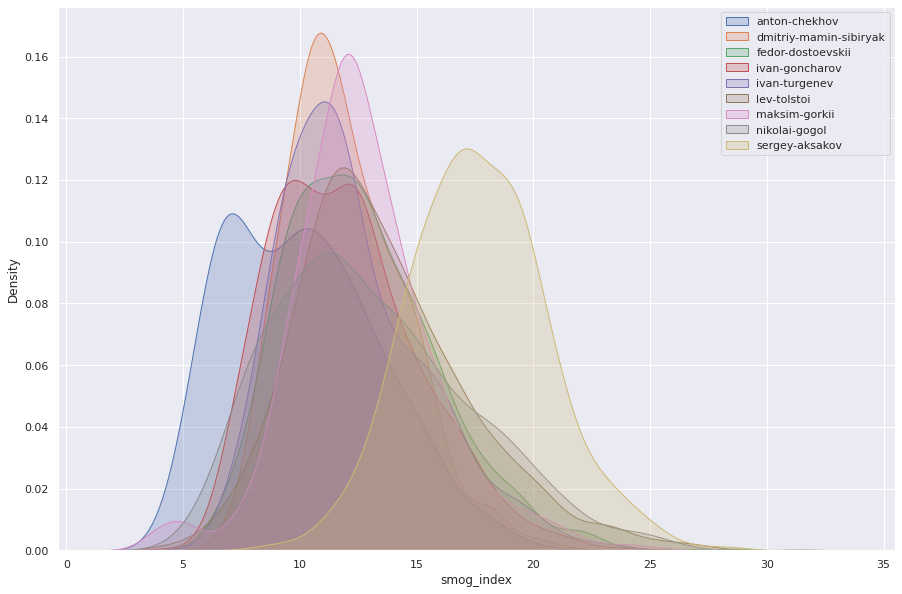

In [272]:
metrics_density_by_author('smog_index')

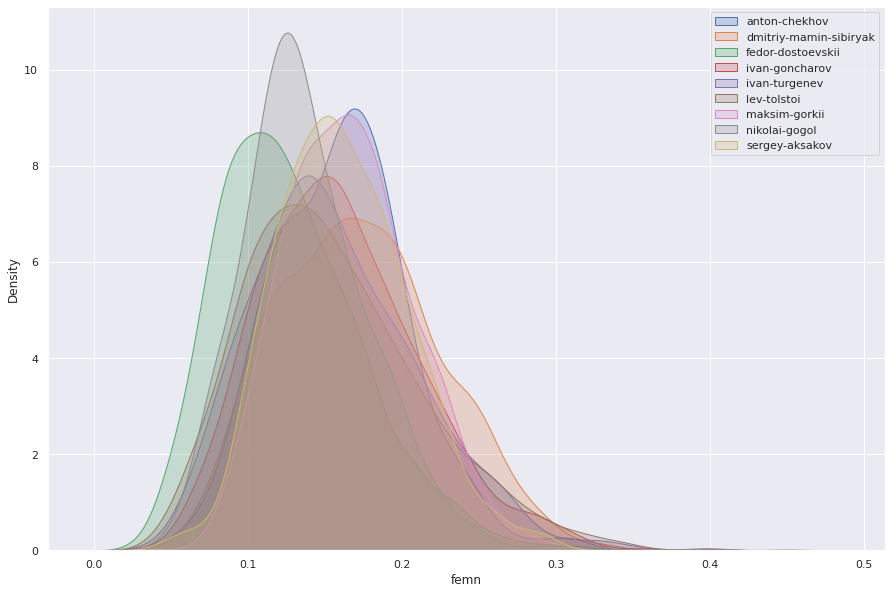

In [273]:
metrics_density_by_author('femn')

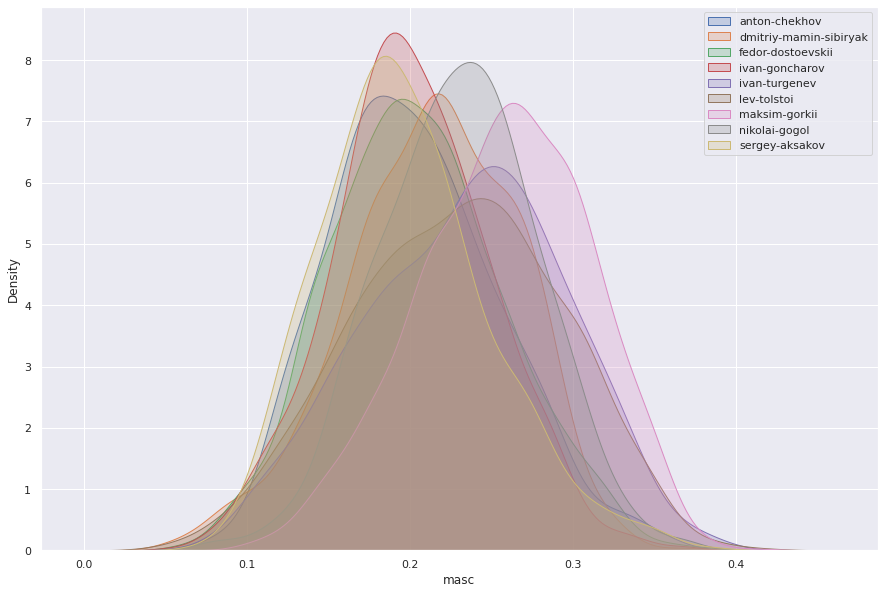

In [274]:
metrics_density_by_author('masc')

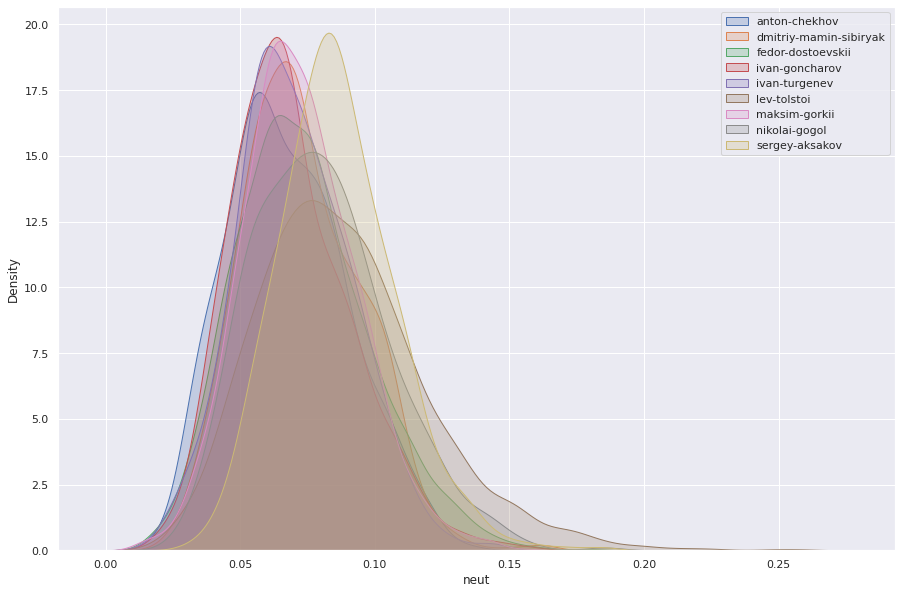

In [275]:
metrics_density_by_author('neut')

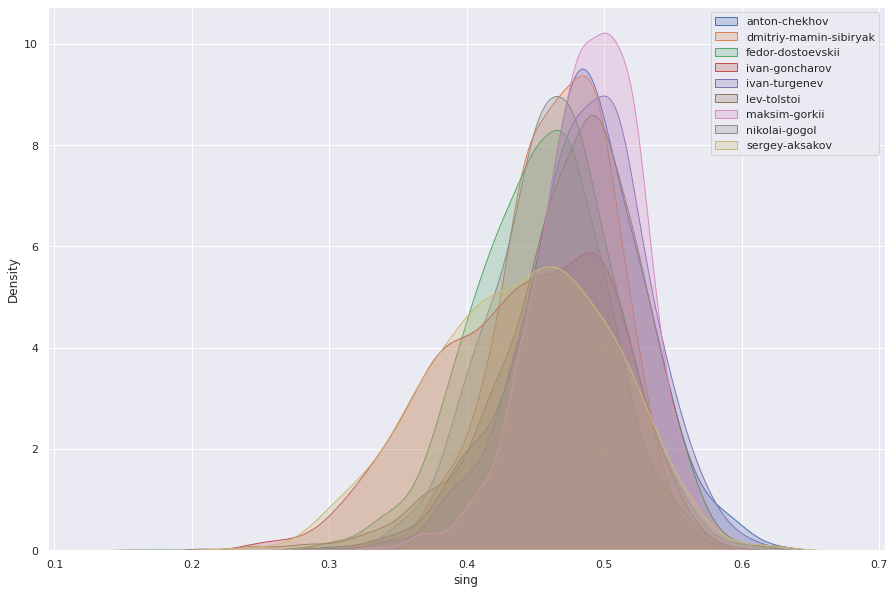

In [276]:
metrics_density_by_author('sing')

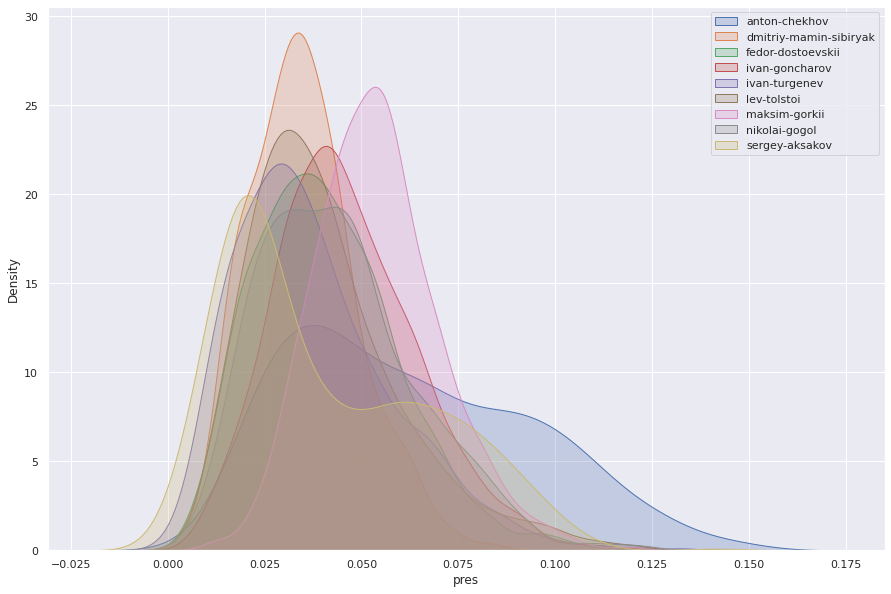

In [277]:
metrics_density_by_author('pres')

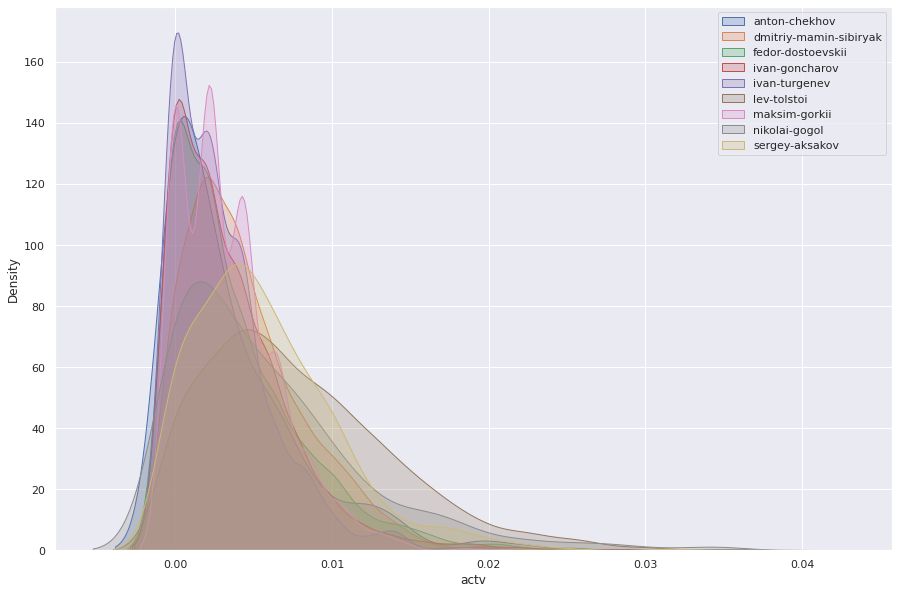

In [278]:
metrics_density_by_author('actv')

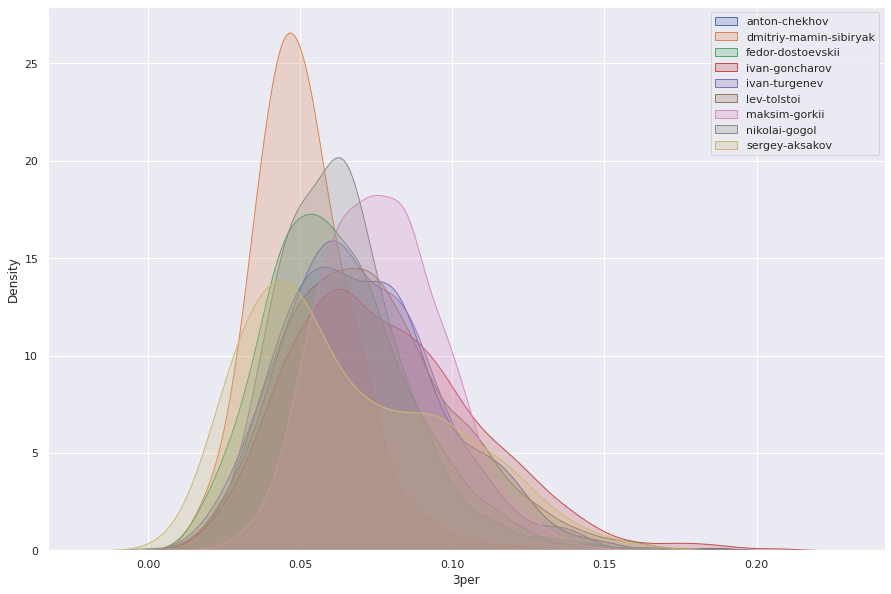

In [279]:
metrics_density_by_author('3per')

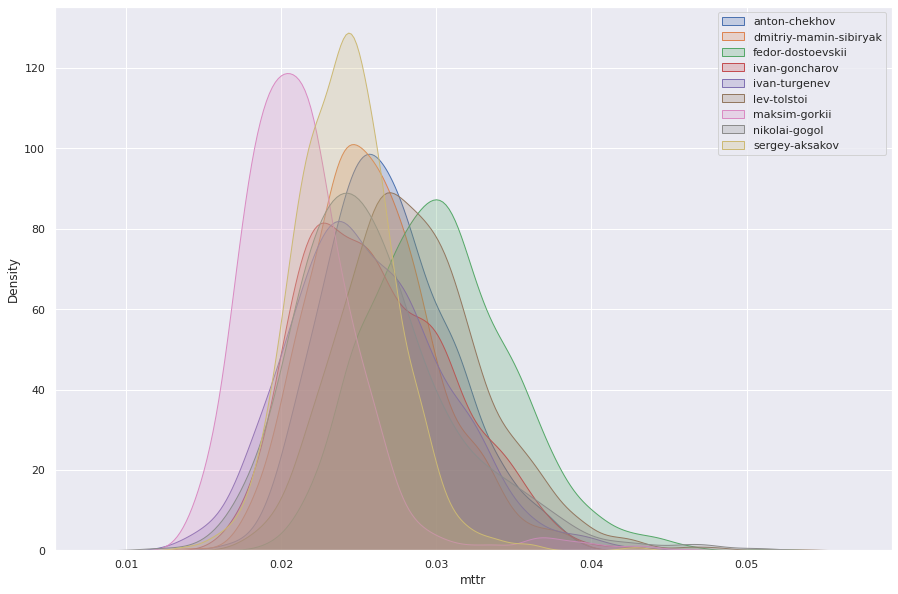

In [280]:
metrics_density_by_author('mttr')

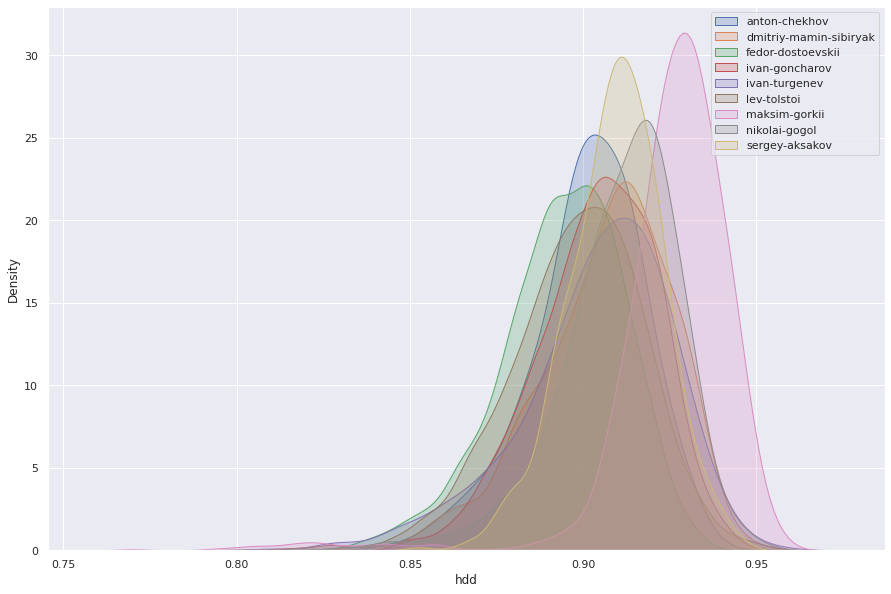

In [281]:
metrics_density_by_author('hdd')

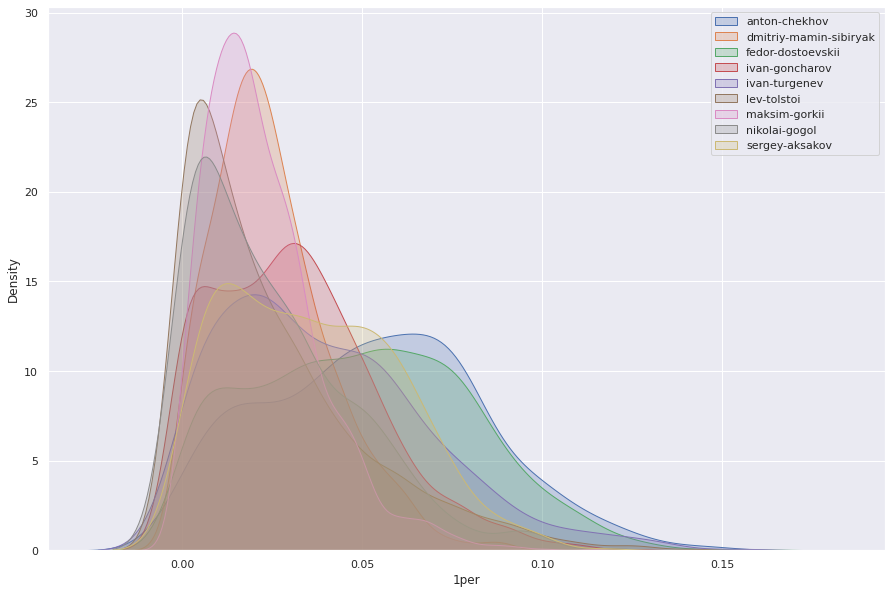

In [282]:
metrics_density_by_author('1per')

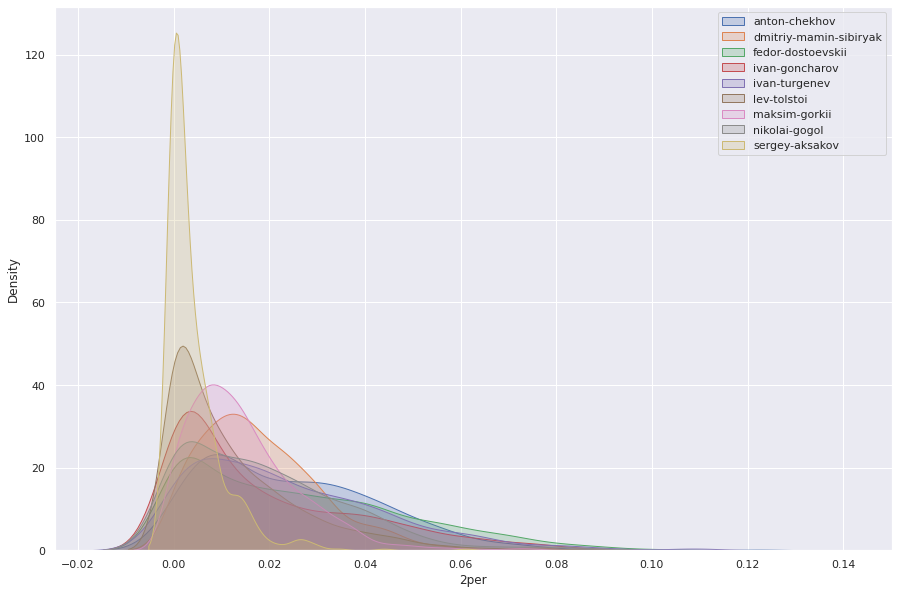

In [283]:
metrics_density_by_author('2per')

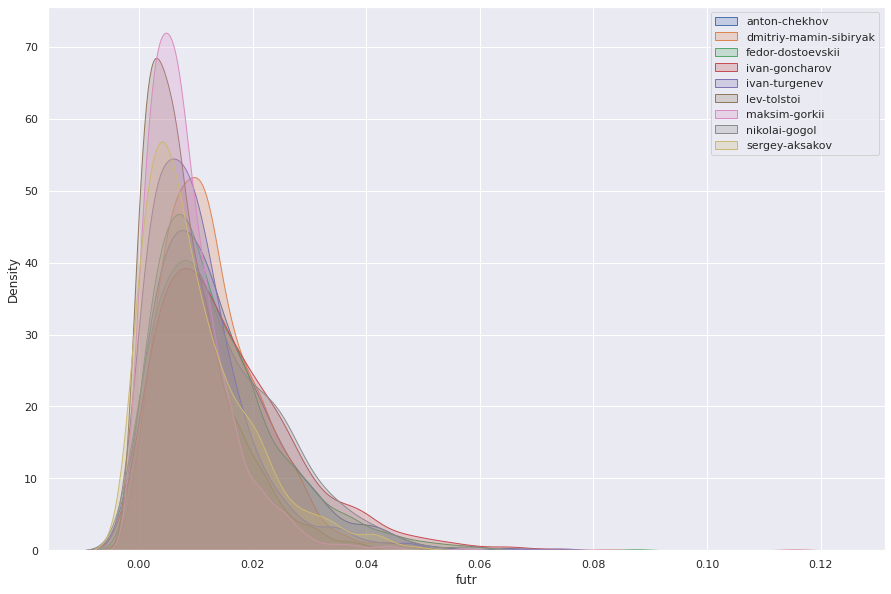

In [284]:
metrics_density_by_author('futr')

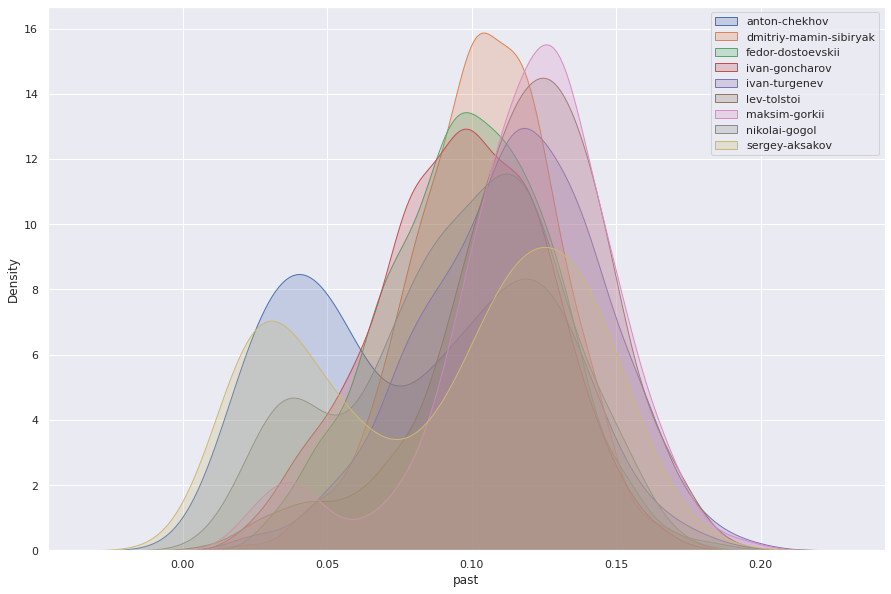

In [285]:
metrics_density_by_author('past')

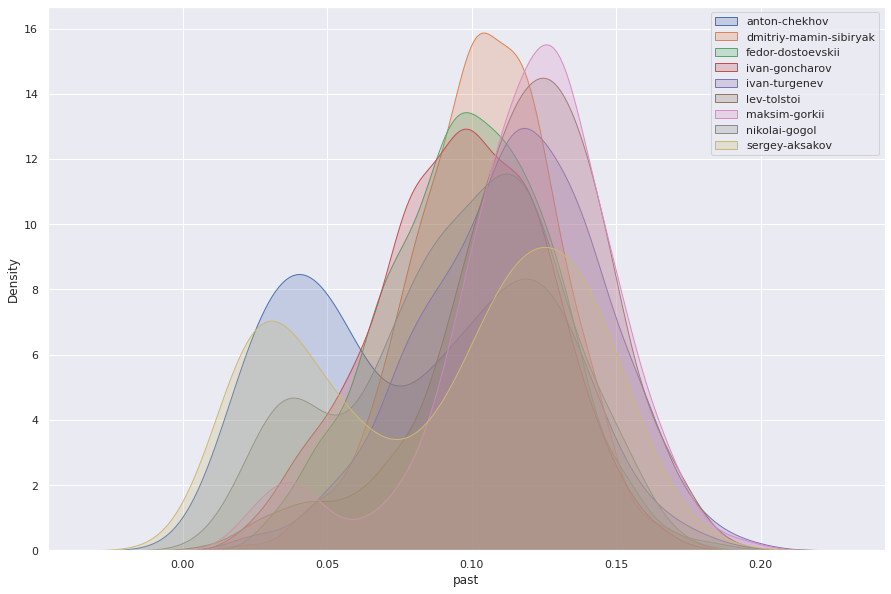

In [286]:
metrics_density_by_author('past')

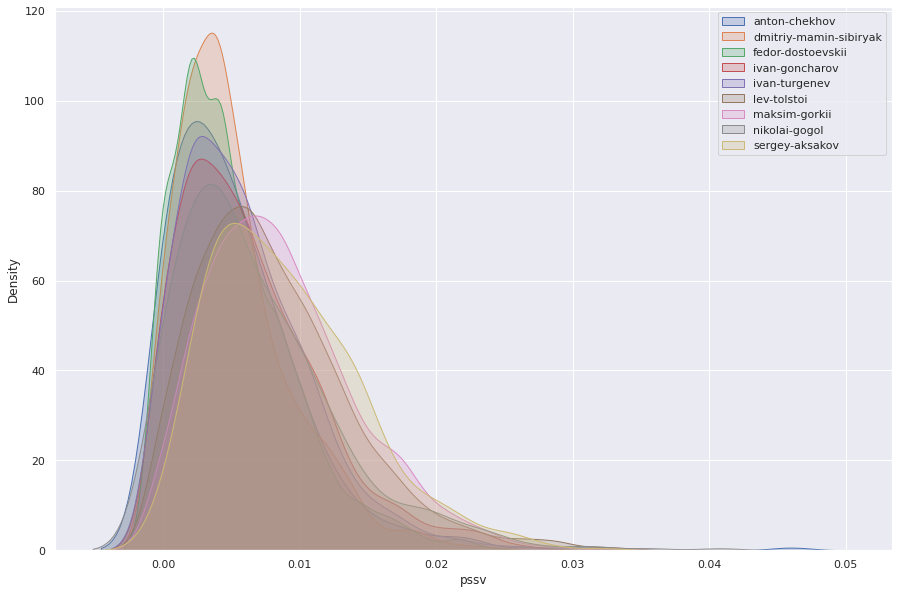

In [287]:
metrics_density_by_author('pssv')

In [288]:
books.drop(['author', 'author_num'], axis=1).columns

Index(['smog_index', 'masc', 'femn', 'neut', 'sing', 'plur', 'past', 'pres',
       'futr', 'pssv', 'actv', '3per', '1per', '2per', 'mttr', 'hdd'],
      dtype='object')

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


[Text(0.5, 1.0, 'Авторы')]

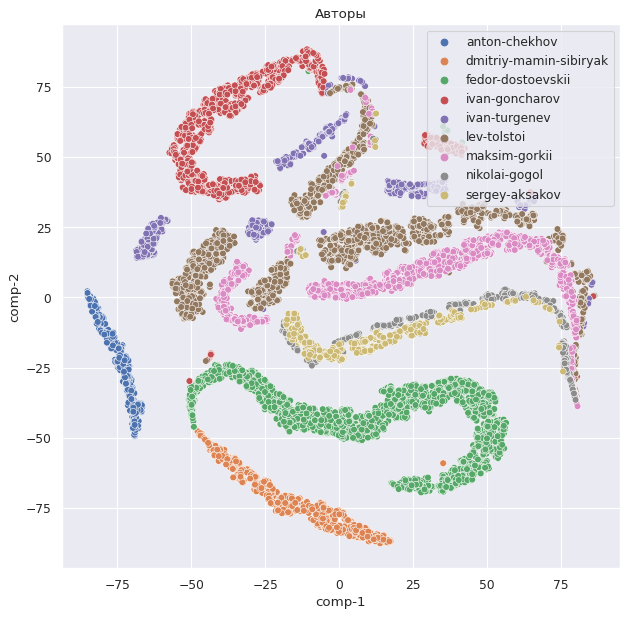

In [289]:
X = books_norm.drop(['author_num'], axis=1)

y = books['author']

plt.figure(figsize=(9,9), dpi=80)
tsne = TSNE(n_components=2, learning_rate=170)
z = tsne.fit_transform(X)

d = pd.DataFrame()
d["y"] = y
d["comp-1"] = z[:,0]
d["comp-2"] = z[:,1]

sns.scatterplot(x="comp-1", y="comp-2", hue=d.y.tolist(), data=d).set(title="Авторы") 

In [290]:
books.shape

(9751, 18)

In [291]:
books.columns

Index(['smog_index', 'masc', 'femn', 'neut', 'sing', 'plur', 'past', 'pres',
       'futr', 'pssv', 'actv', '3per', '1per', '2per', 'mttr', 'hdd', 'author',
       'author_num'],
      dtype='object')

In [306]:
books.to_csv('TRAIN_500words_lemmatized_metrics.csv')

# Обучение моделей

## 1. Импорт и обработка теста

In [7]:
# импорт тестового датасета

books = pd.read_csv('TRAIN_500words_lemmatized_metrics.csv', sep=',')
test = pd.read_csv('TEST_500words_lemmatized_metrics.csv', sep=',') 

for column in ['neut',
       'masc', 'femn', 'plur','sing', 'pres', 'past', 'futr', 'pssv', 'actv', '2per',
       '3per', '1per']:
    test[column] = test[column] / test['n_words'] # делаем проценты вместо чисел для некоторых показателей

test.drop(['flesch_kincaid_grade', 'flesch_reading_easy', 'coleman_liau_index', 'automated_readability_index',
                    'ttr', 'rttr', 'cttr', 'httr', 'sttr', 'dttr', 'mattr', 'msttr', 'mamtld', 'hapax_index', 'mtld', 
                    'simpson_index', 'lix'], axis=1, inplace=True) # удаляем очень похожие метрики

test.index = test['Unnamed: 0'] # переопределяем индекс

test.drop(['n_sents', 'n_words', 'n_unique_words', 'n_long_words',
       'n_complex_words', 'n_simple_words', 'n_monosyllable_words',
       'n_polysyllable_words', 'n_chars', 'n_letters', 'n_spaces',
       'n_syllables', 'n_punctuations', 'Unnamed: 22', 'Unnamed: 0'], axis=1, inplace=True)  # удаляем метрики, которые зависят от длины

print(test.shape)

(2033, 17)


In [9]:
# создание переменных для трейна и теста

X_train = books.drop(['author', 'author_num', 'Unnamed: 0'], axis=1)
y_train = books['author']

X_test = test.drop(['author'], axis=1).reindex(columns=X_train.columns).fillna(value=0)
y_test = test['author']

In [10]:
print(X_train.shape, X_train.columns)
print(X_test.shape, X_test.columns)

(9751, 16) Index(['smog_index', 'masc', 'femn', 'neut', 'sing', 'plur', 'past', 'pres',
       'futr', 'pssv', 'actv', '3per', '1per', '2per', 'mttr', 'hdd'],
      dtype='object')
(2033, 16) Index(['smog_index', 'masc', 'femn', 'neut', 'sing', 'plur', 'past', 'pres',
       'futr', 'pssv', 'actv', '3per', '1per', '2per', 'mttr', 'hdd'],
      dtype='object')


In [11]:
#from sklearn.preprocessing import OneHotEncoder

#y_train_enc = OneHotEncoder().fit_transform(np.array(y_train).reshape(-1, 1)).toarray()

## 2. Логистическая регрессия

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [341]:
parameters = {'C': np.arange(10, 50, 1)}

model = LogisticRegression(multi_class='multinomial', max_iter=10000)
gs = GridSearchCV(model, parameters)

gs.fit(X_train, y_train)

gs.best_estimator_

LogisticRegression(C=45, max_iter=10000, multi_class='multinomial')

In [14]:
best_model = LogisticRegression(multi_class='multinomial', max_iter=10000, C=45)
best_model.fit(X_train, y_train)

pred_logreg = best_model.predict(X_test)

f1_score(y_test, pred_logreg, average='micro')

0.411706837186424

In [16]:
best_model.classes_

array(['anton-chekhov', 'dmitriy-mamin-sibiryak', 'fedor-dostoevskii',
       'ivan-goncharov', 'ivan-turgenev', 'lev-tolstoi', 'maksim-gorkii',
       'nikolai-gogol', 'sergey-aksakov'], dtype=object)

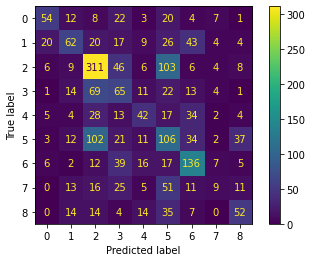

In [17]:
cm = confusion_matrix(y_test, pred_logreg)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot() # больше всего правильно угадывает Достоевского, но и часто путает его с Толстым

## 3. KNN

In [333]:
from sklearn.neighbors import KNeighborsClassifier

parameters = {'n_neighbors': np.arange(3, 20, 2), 'weights': ['uniform', 'distance']}

model = KNeighborsClassifier()
gs = GridSearchCV(model, parameters)

gs.fit(X_train, y_train)

gs.best_estimator_

KNeighborsClassifier(n_neighbors=15, weights='distance')

In [334]:
best_model = gs.best_estimator_
best_model.fit(X_train, y_train)

pred_kn = best_model.predict(X_test)

f1_score(y_test, pred_kn, average='micro')

0.33300541072306933

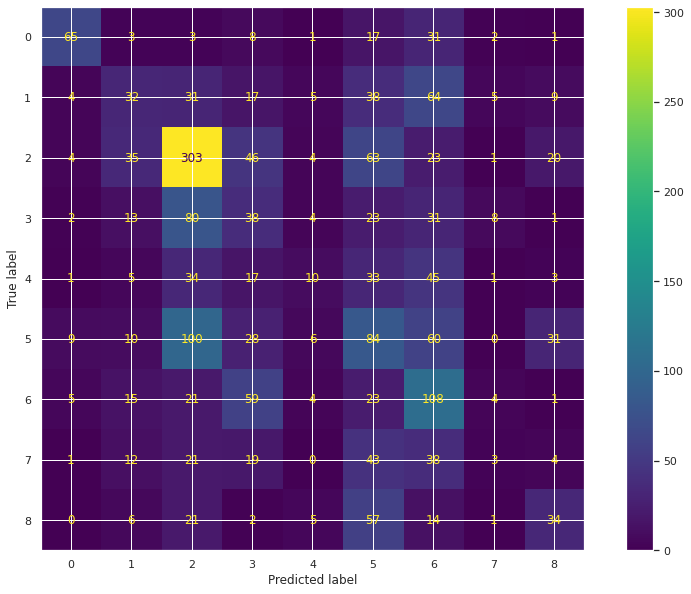

In [335]:
cm = confusion_matrix(y_test, pred_kn)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

## 4. Catboost

In [303]:
#!pip install catboost
from sklearn.model_selection import train_test_split as tts
from catboost import CatBoostClassifier
from catboost import Pool
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [336]:
model = CatBoostClassifier()
model.fit(X_train, y_train, silent=True)

In [337]:
preds = model.predict(X_test)
f1_score(preds, y_test, average='micro')

0.411706837186424

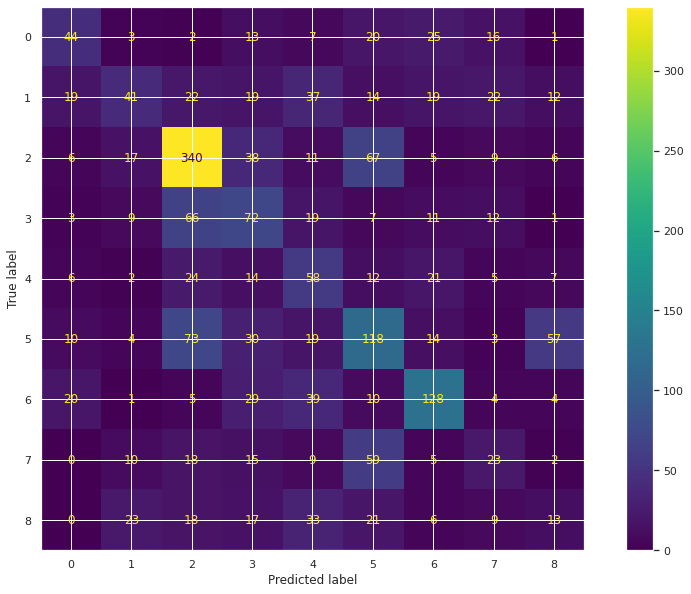

In [338]:
cm = confusion_matrix(y_test, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot() 

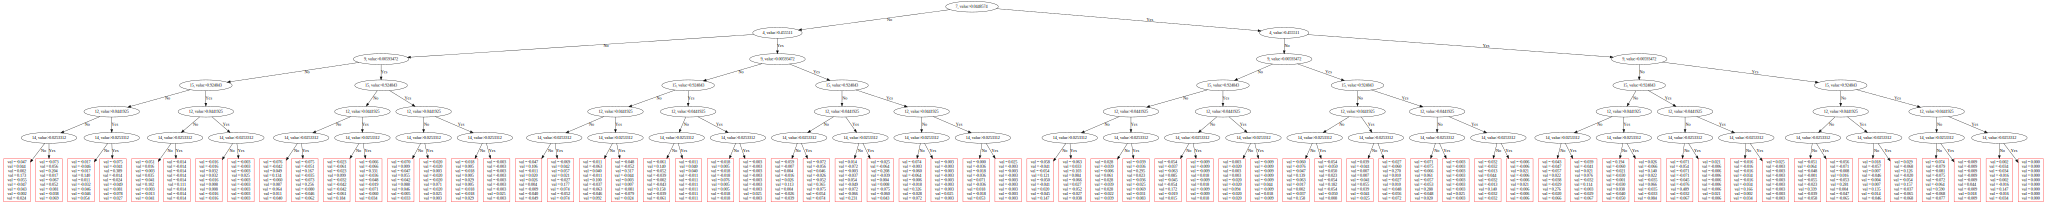

In [339]:
model.plot_tree(tree_idx=0)